# COMENTARIOS

* En este dataset se busca info con personas. Por eso, se pierden las filas donde hay problemas con la persona

# Información 

1. Descricpción del problema
1. Data cleaning 
1. Data formatting
1. EDA
3. Feature selecction y engenieering
4. Comparación de modelos
5. Hyperparameter tunning sobre el mejor modelo
6. Evaluacion
7. Interpretación
8. Conclusión

OBJETIVO: Determinar que personas van a ser morosos en los prestamos

# 0. IMPORTACIONES Y SETEOS

## Imports 

In [1]:
# Pandas y numpy para manipulación
import pandas as pd
import numpy as np
# Librerias para gráficos 
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de DS
import DSImplementation as dsimp
# Funciones para analizar valores faltantes 
import missingno as msno

## Seteos

In [2]:
# Para evitar que salgan advertencias por usar dataframes sin un .copy()
pd.options.mode.chained_assignment = None

# Se setea un maximo de 60 columnas para visualizar
pd.set_option('display.max_columns', 60)

# Matplotlib visualización en la celda
%matplotlib inline

# 1. DESCRIPCIÓN DEL PROBLEMA 

* Fecha_Pago: fecha cuando la persona pago la cuota del prestamo. Es diferente a la fecha de acreditación. 
* Vencimiento: fecha en la cual vence el prestamos, y hay algunos prestamos con doble fecha de vencimiento. El primer vencimiento es siempre el 20 y el segundo es el 30. No todos los tipos de linea de prestamos admiten segundo vencimiento. 
* Tipo de prestamo: numero de ID, cada ID corresponde a un barrio diferente. El IVC construye de a un barrio por vez. Puede pasar que para un mismo barrio puedo tener diferentes tipo de prestamo (linea de prestamo). 
* Numero_Prestamo: Es el ID del prestamo. Es unico y no se repite
* Total_prestamo[CALCULADO]: el total que tiene que pagar para el prestamos, no es lo que le falta. Se calcula como suma de capital, interes y gastos.
* Total_cutas: cantidad de cuotas que tiene el prestamo
* Numero de cuota: es la cuota que se esta pagando. Se permite saltear cuotas, es decir, se puede no pagar la 16 y pagar la 17. De esta forma la persona quedaria adeudnado la cuota 16.
* Pago: monto del recibo de pago. Cada pago puede no corresponder a una unica cuota. Puede ser una de cuatro opciones: Pago de cuota completa, pago parcial de cuota, adelanto de cuota, pago completo del prestamo. 
* Genero: Masculino o Femenino, binario
* Edad[CALCULADO]: la edad del que pide el prestamo
* Paga_en_termino [CALCULADO]: si pago antes del vencimiento. A partir de 2021 se introdujo segundo vencimiento (el 30). 1 es que esta en termino, 0 que no pago en termino
* Refinaciado [CALCULADO] : indica si el prestamo fue refinanciado en el pasado. Es decir, cuando se reestructura la deuda. 1 es que esta refinanciado, 0 que no esta refinanciado. 


Nuestro campo targe es "Pagado en termino" para evaluar si el mes que viene me van a pagar o no 

Columnas a agregar:

* Numerico indicando tipo de pago. 1: Pago de cuota completa, 2: pago parcial de cuota, 3: adelanto de cuota, 4: pago completo del prestamo
* Faltante total a pagar: el monto que falta pagar del prestamo

Preguntas:

* Agrego columnas que traiga cantidad de cuotas no pagas en terminas para ese prestamo por esa persona?


# 2. DATA CLEANING

## Carga del dataset a trabajar 

In [3]:
# Se carga el dataset
df = pd.read_csv('Data/DATASET TP4 VERSION 7 2015-2019 correjido.csv', sep=';')
df.head(5)

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
0,02/01/2015,20/02/2015,974,1091205,16090435.0,"181874,40",240,119,"0,50","623,82","0,34",Masculino,42.0,1,0
1,02/01/2015,20/01/2015,974,1091205,16090435.0,"181874,40",240,118,"0,51","623,82","0,34",Masculino,42.0,1,0
2,02/01/2015,20/03/2015,974,1091205,16090435.0,"181874,40",240,120,"0,50","623,82","0,34",Masculino,42.0,1,0
3,02/01/2015,20/01/2015,955,1095467,2115837.0,"14180,19",360,102,"0,72","45,26","0,32",Femenino,95.0,1,0
4,02/01/2015,20/02/2015,877,10991758,25238393.0,"551452,31",360,45,"0,88","993,63","0,18",NaN,45.0,1,0


In [4]:
# Unifico nombre de columnas
columns_names_new = list(map(lambda x: x.lower(), df.columns))
df.columns = columns_names_new
df.head()

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado
0,02/01/2015,20/02/2015,974,1091205,16090435.0,"181874,40",240,119,"0,50","623,82","0,34",Masculino,42.0,1,0
1,02/01/2015,20/01/2015,974,1091205,16090435.0,"181874,40",240,118,"0,51","623,82","0,34",Masculino,42.0,1,0
2,02/01/2015,20/03/2015,974,1091205,16090435.0,"181874,40",240,120,"0,50","623,82","0,34",Masculino,42.0,1,0
3,02/01/2015,20/01/2015,955,1095467,2115837.0,"14180,19",360,102,"0,72","45,26","0,32",Femenino,95.0,1,0
4,02/01/2015,20/02/2015,877,10991758,25238393.0,"551452,31",360,45,"0,88","993,63","0,18",NaN,45.0,1,0


## Tipo de datos, valores faltantes y valores nulos 

In [5]:
# Cantidad de datos totales
rows_n, cols_n = df.shape
print(rows_n, cols_n)

763877 15


### Valores nulos y tipo de datos 

In [6]:
# Se observa los tipos de columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763877 entries, 0 to 763876
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   fecha_pago                          763877 non-null  object 
 1   vencimiento                         763877 non-null  object 
 2   tipo_prestamo                       763877 non-null  int64  
 3   numero_prestamo                     763877 non-null  int64  
 4   dni                                 649441 non-null  float64
 5   total_prestamo                      763877 non-null  object 
 6   total_cuotas                        763877 non-null  int64  
 7   numero_cuota                        763877 non-null  int64  
 8   porcentaje_de_cuotas_faltantes      763877 non-null  object 
 9   pago                                763877 non-null  object 
 10  porcentaje_de_cuota_sobre_prestamo  763877 non-null  object 
 11  genero                    

In [7]:
# Detectamos valores faltantes en genero
dsimp.missing_values_table(df)

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
genero,326688,42.8
edad,299550,39.2
dni,114436,15.0


Detectamos Valores faltantes en GENERO; EDAD Y DNI

<AxesSubplot:>

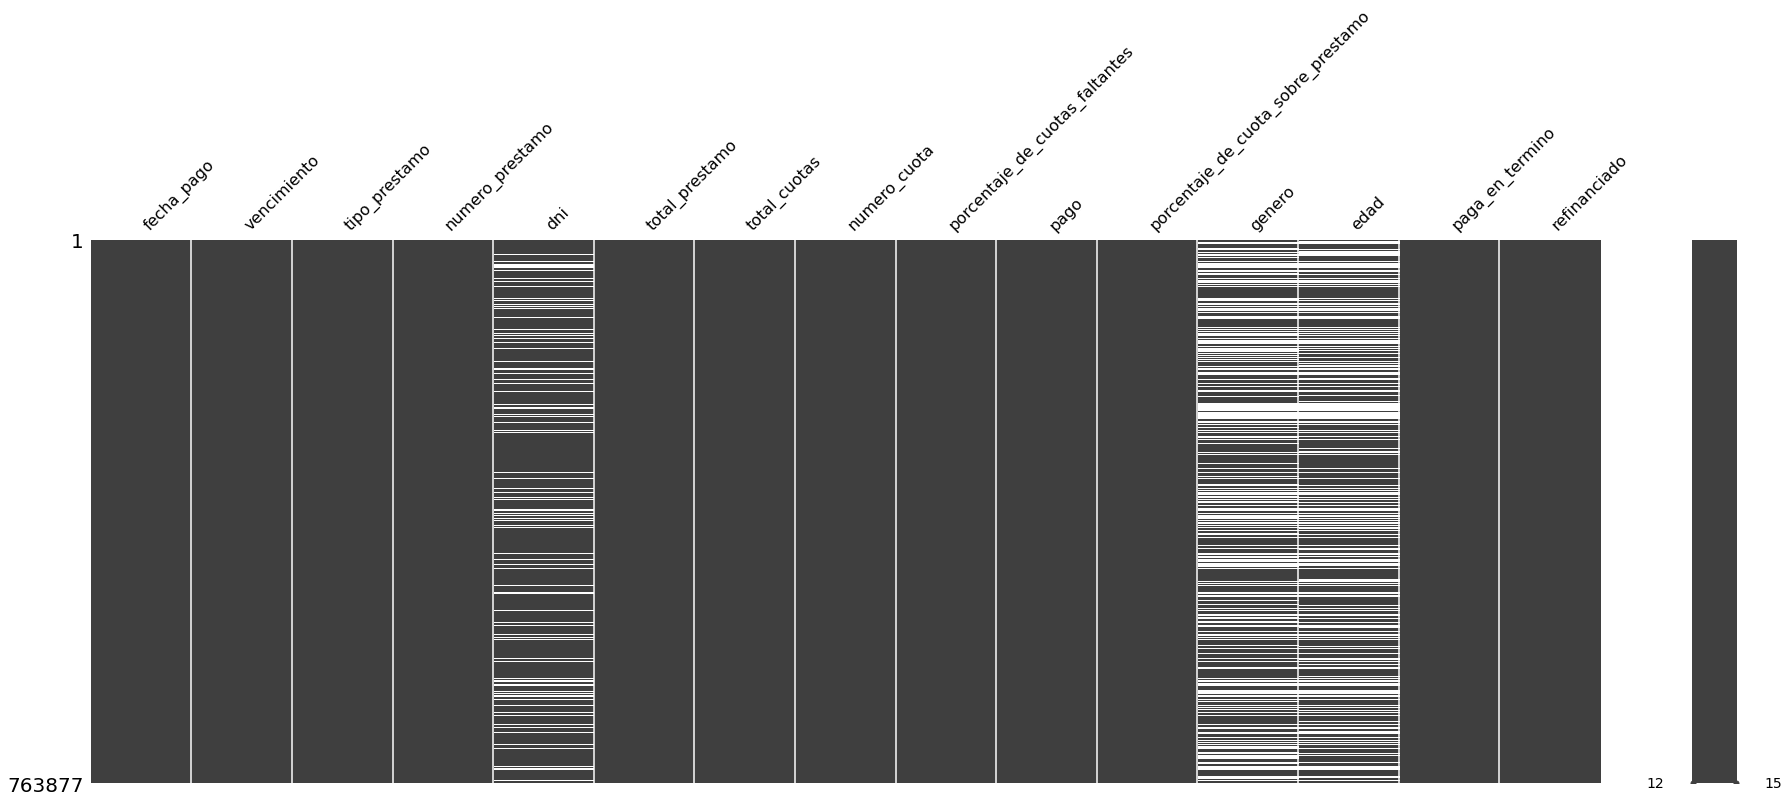

In [8]:
# Detectamos valores faltantes
msno.matrix(df, figsize=(30,10))

## Chequeo que para cada DNI exista una unica edad y genero

In [9]:
dni_df = df[['dni', 'edad', 'genero']]

In [10]:
dni_uniques = dni_df.groupby('dni')['edad','genero'].nunique()
dni_uniques.head(3)

C:\Users\Fran\AppData\Local\Temp/ipykernel_8848/2013069165.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dni_uniques = dni_df.groupby('dni')['edad','genero'].nunique()


,edad,genero
dni,,
2.0,0,0
9.0,1,1
29.0,1,1


In [11]:
# Obtengo los DNI que tengan mas de una edad o genero
dni_error = dni_uniques[(dni_uniques>1).any(axis=1)].index
dni_error

Float64Index([ 3073270.0,  4305479.0,  4954272.0,  4991124.0,  5087952.0,
               5124029.0,  5138405.0,  5201050.0,  5282162.0,  5570811.0,
               5594257.0,  5658001.0,  5665791.0,  6084686.0,  6147893.0,
               6245394.0,  6371629.0,  6519814.0,  6536437.0,  6652650.0,
               7162249.0,  7377515.0,  7704965.0,  8252165.0,  8326485.0,
               8400924.0,  8514256.0,  8633243.0, 10174146.0, 10758672.0,
              11241030.0, 11469042.0, 11768623.0, 12702446.0, 12712566.0,
              13285676.0, 14317845.0, 16051677.0, 16315055.0, 16938614.0,
              17046748.0, 17187923.0, 17283305.0, 17563244.0, 17614252.0,
              18328611.0, 18387076.0, 18404973.0, 18652869.0, 20351439.0,
              20389809.0, 20986191.0, 21640157.0, 24905162.0, 25228398.0,
              92028416.0, 92089425.0, 92099674.0, 92244256.0, 92452663.0,
              92640824.0, 92676137.0, 92840561.0, 92903683.0, 92940304.0,
              92947290.0, 92950018.0, 

In [12]:
df_1_sin_dni_error = df.loc[~df['dni'].isin(dni_error)]

### Genero y edad 

In [13]:
# Separado las columnas que no tienen problemas de las que si
columns_problem = ['genero', 'edad']
columns_ok = list(set(df.columns) - set(columns_problem))

In [14]:
#  Chequeo filas duplicadas del dataset, habiendo sacado las columnas de genero y edad
df_1_sin_dni_error[columns_ok].duplicated().sum()

65590

In [15]:
# Mergeo las filas duplicadas remplazando los valores nulos de genero y edad
df_2_sin_dup =df_1_sin_dni_error.groupby(columns_ok)[columns_problem].first().reset_index()

In [16]:
# chequeo valores faltantes
dsimp.missing_values_table(df_2_sin_dup)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
genero,142829,24.8
edad,121511,21.1


In [17]:
# ya no tengo filas duplicadas
df_2_sin_dup[columns_ok].duplicated().sum()

0

In [18]:
# separo los dni que tienen valores nulos
dni_gen_null = df_2_sin_dup.loc[df_2_sin_dup['genero'].isnull(), 'dni']
dni_edad_null = df_2_sin_dup.loc[df_2_sin_dup['edad'].isnull(), 'dni']

### Busco completar el genero que sigue en NAN

In [19]:
# trato de ver si puedo traer el genero del dni
df.loc[(df['dni'].isin(dni_gen_null)) & (~df['genero'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


### Busco completar la edad que sigue en NAN

In [20]:
# trato de ver si puedo traer la edad del los dni faltantes buscandolos en el dataset  original
df.loc[(df['dni'].isin(dni_edad_null)) & (~df['edad'].isnull())]

,fecha_pago,vencimiento,tipo_prestamo,numero_prestamo,dni,total_prestamo,total_cuotas,numero_cuota,porcentaje_de_cuotas_faltantes,pago,porcentaje_de_cuota_sobre_prestamo,genero,edad,paga_en_termino,refinanciado


In [21]:
# No puedo completar las filas asi que las saco
df_3_sin_nan = df_2_sin_dup.dropna()

In [22]:
# chequeo valores faltantes
dsimp.missing_values_table(df_3_sin_nan)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# 3. DATA FORMATING

In [23]:
df_4_parsed = df_3_sin_nan.copy()

In [24]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 17 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   total_cuotas                        395516 non-null  int64  
 1   porcentaje_de_cuota_sobre_prestamo  395516 non-null  object 
 2   pago                                395516 non-null  object 
 3   paga_en_termino                     395516 non-null  int64  
 4   refinanciado                        395516 non-null  int64  
 5   vencimiento                         395516 non-null  object 
 6   numero_prestamo                     395516 non-null  int64  
 7   dni                                 395516 non-null  float64
 8   fecha_pago                          395516 non-null  object 
 9   numero_cuota                        395516 non-null  int64  
 10  total_prestamo                      395516 non-null  object 
 11  porcentaje_de_cuotas_falt

 ### Análisis de los tipo de de columna

In [25]:
# Columnas que son de tipo objeto
df_4_parsed.select_dtypes(include="object").columns

Index(['porcentaje_de_cuota_sobre_prestamo', 'pago', 'vencimiento',
       'fecha_pago', 'total_prestamo', 'porcentaje_de_cuotas_faltantes',
       'genero'],
      dtype='object')

In [26]:
# Columnas que son de tipo float
df_4_parsed.select_dtypes(include="float").columns

Index(['dni', 'edad'], dtype='object')

In [27]:
# Columnas que son de tipo int
df_4_parsed.select_dtypes(include="int").columns

Index(['total_cuotas', 'paga_en_termino', 'refinanciado', 'numero_prestamo',
       'numero_cuota', 'tipo_prestamo'],
      dtype='object')

### Parseo de columnas str a float

In [28]:
# Parceo a tipo float
columns_to_float = ['pago', 'total_prestamo', 'porcentaje_de_cuotas_faltantes',  'porcentaje_de_cuota_sobre_prestamo']
for column in columns_to_float:
    df_4_parsed[column] = df_3_sin_nan[column].str.replace(',','.').astype('float')

In [29]:
df_4_parsed[columns_to_float].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 17 to 575915
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   pago                                395516 non-null  float64
 1   total_prestamo                      395516 non-null  float64
 2   porcentaje_de_cuotas_faltantes      395516 non-null  float64
 3   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64
dtypes: float64(4)
memory usage: 15.1 MB


In [30]:
df_4_parsed[columns_to_float].describe().apply(lambda col: col.apply('{0:.5f}'.format))

,pago,total_prestamo,porcentaje_de_cuotas_faltantes,porcentaje_de_cuota_sobre_prestamo
count,395516.00000,395516.00000,395516.00000,395516.00000
mean,5613.99243,207312.16066,0.69413,0.75141
std,122692.01370,439371.30052,0.21966,4.72712
min,1.01000,94.74000,0.00000,0.00000
25%,58.04000,20001.68000,0.59000,0.23000
50%,201.81000,66939.97000,0.72000,0.30000
75%,453.00000,152827.93000,0.86000,0.40000
max,6680660.81000,7951994.75000,1.00000,105.56000


### Parseo de columnas str a date

In [111]:
# Se convierten las columnas de tipo object a tipo date 
columns_to_dates = ['fecha_pago', 'vencimiento']
df_4_parsed[columns_to_dates] =df_4_parsed[columns_to_dates].astype('datetime64[ns]')

### Formato final

In [32]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 17 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   total_cuotas                        395516 non-null  int64         
 1   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 2   pago                                395516 non-null  float64       
 3   paga_en_termino                     395516 non-null  int64         
 4   refinanciado                        395516 non-null  int64         
 5   vencimiento                         395516 non-null  datetime64[ns]
 6   numero_prestamo                     395516 non-null  int64         
 7   dni                                 395516 non-null  float64       
 8   fecha_pago                          395516 non-null  datetime64[ns]
 9   numero_cuota                        395516 non-null  int64         
 10  total_p

# 4. EDA

## Analisis variable objetivo

Primero se inicia analizando la variable target para analizar si se encuentra balanceado el data set. Observamos que sigue una distribución uniforme, con lo cual no vamos a necesitar recurrir a SMOTE para balancearlo. Concluimos que:

* El dataset se encuentra balanceado
* No se observa presencia de anomalias o outliers

Text(0.5, 1.0, 'Balance de la variable objetivo "Paga_en_Termino"')

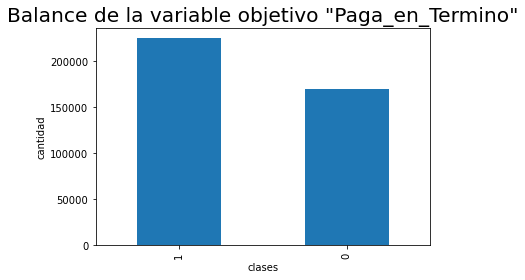

In [33]:
# Grafico
df_4_parsed['paga_en_termino'].value_counts().plot(kind='bar')
# Seteos del gráfico
plt.style.use('fivethirtyeight')
plt.xlabel('clases')
plt.ylabel ('cantidad')
plt.title('Balance de la variable objetivo "Paga_en_Termino"')

## Análisis de variables  

In [34]:
df_4_parsed.columns

Index(['total_cuotas', 'porcentaje_de_cuota_sobre_prestamo', 'pago',
       'paga_en_termino', 'refinanciado', 'vencimiento', 'numero_prestamo',
       'dni', 'fecha_pago', 'numero_cuota', 'total_prestamo',
       'porcentaje_de_cuotas_faltantes', 'tipo_prestamo', 'genero', 'edad'],
      dtype='object')

In [35]:
columns_data = ['total_cuotas', 'fecha_pago', 'numero_cuota', 'refinanciado', 'tipo_prestamo', 'pago', 'vencimiento',
                'total_prestamo','porcentaje_de_cuota_sobre_prestamo', 'paga_en_termino', 'porcentaje_de_cuotas_faltantes',  
               'genero', 'edad']

In [36]:
df_4_parsed.describe(include='all')

C:\Users\Fran\AppData\Local\Temp/ipykernel_8848/161478326.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_4_parsed.describe(include='all')


,total_cuotas,porcentaje_de_cuota_sobre_prestamo,pago,paga_en_termino,refinanciado,vencimiento,numero_prestamo,dni,fecha_pago,numero_cuota,total_prestamo,porcentaje_de_cuotas_faltantes,tipo_prestamo,genero,edad
count,395516.000000,395516.000000,3.955160e+05,395516.000000,395516.000000,395516,3.955160e+05,3.955160e+05,395516,395516.000000,3.955160e+05,395516.000000,395516.000000,395516,395516.000000
unique,NaN,NaN,NaN,NaN,NaN,920,NaN,NaN,1722,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,2018-11-20 00:00:00,NaN,NaN,2018-01-22 00:00:00,NaN,NaN,NaN,NaN,Masculino,NaN
freq,NaN,NaN,NaN,NaN,NaN,6413,NaN,NaN,2062,NaN,NaN,NaN,NaN,214486,NaN
first,NaN,NaN,NaN,NaN,NaN,1997-09-22 00:00:00,NaN,NaN,2015-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2025-11-20 00:00:00,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,277.117313,0.751407,5.613992e+03,0.569304,0.019236,NaN,7.231048e+06,2.854829e+07,NaN,76.516356,2.073122e+05,0.694132,738.070306,NaN,54.061196
std,115.460061,4.727115,1.226920e+05,0.495174,0.137352,NaN,4.739496e+06,2.798373e+07,NaN,55.638796,4.393713e+05,0.219655,334.205292,NaN,15.488148
min,1.000000,0.000000,1.010000e+00,0.000000,0.000000,NaN,1.070590e+05,9.000000e+00,NaN,1.000000,9.474000e+01,0.000000,1.000000,NaN,3.000000
25%,188.000000,0.230000,5.804000e+01,0.000000,0.000000,NaN,1.093507e+06,1.213174e+07,NaN,27.000000,2.000168e+04,0.590000,480.000000,NaN,43.000000


In [85]:
df_4_parsed.pago

17        105827.60
20        106807.49
21        106807.49
26        108440.63
28        108440.63
            ...    
575911       205.46
575912       206.09
575913       206.12
575914       206.77
575915       207.46
Name: pago, Length: 395516, dtype: float64

<Figure size 432x288 with 0 Axes>

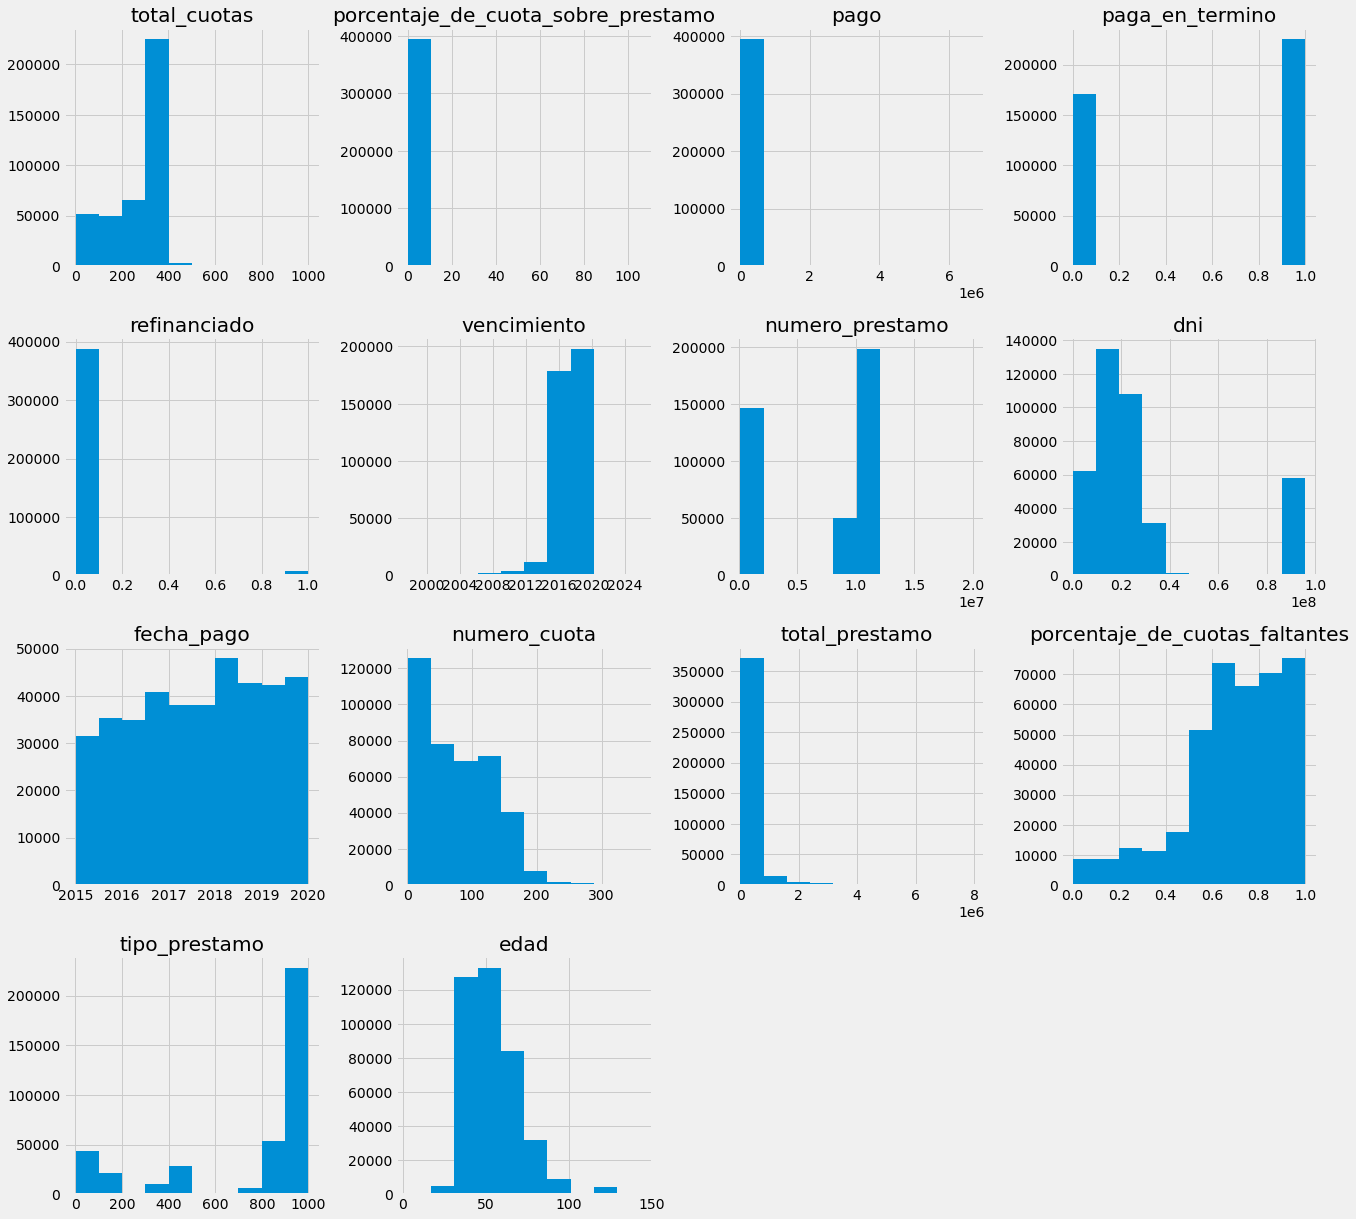

In [37]:
f = plt.figure() 
df_4_parsed.hist(figsize=(20,20))
plt.ticklabel_format(style='plain', axis='x')
plt.show()

### Total cuotas

<AxesSubplot:>

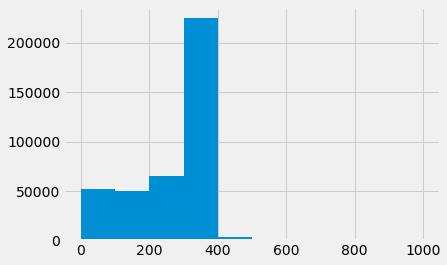

In [113]:
df_4_parsed['total_cuotas'].hist()

In [114]:
df_4_parsed['total_cuotas'].describe()

count    395516.000000
mean        277.117313
std         115.460061
min           1.000000
25%         188.000000
50%         360.000000
75%         360.000000
max         999.000000
Name: total_cuotas, dtype: float64

## Distribución de prestamos entre mujeres, hombres y edades 

In [38]:
df_4_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395516 entries, 17 to 575915
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   total_cuotas                        395516 non-null  int64         
 1   porcentaje_de_cuota_sobre_prestamo  395516 non-null  float64       
 2   pago                                395516 non-null  float64       
 3   paga_en_termino                     395516 non-null  int64         
 4   refinanciado                        395516 non-null  int64         
 5   vencimiento                         395516 non-null  datetime64[ns]
 6   numero_prestamo                     395516 non-null  int64         
 7   dni                                 395516 non-null  float64       
 8   fecha_pago                          395516 non-null  datetime64[ns]
 9   numero_cuota                        395516 non-null  int64         
 10  total_p

In [43]:
df_prestamos = df_4_parsed[['numero_prestamo', 'edad', 'genero']]
df_prestamos = df_prestamos.drop_duplicates()
df_prestamos.groupby(['genero','edad']).count().reset_index()['numero_prestamo'].sum()

10386

### Corr 

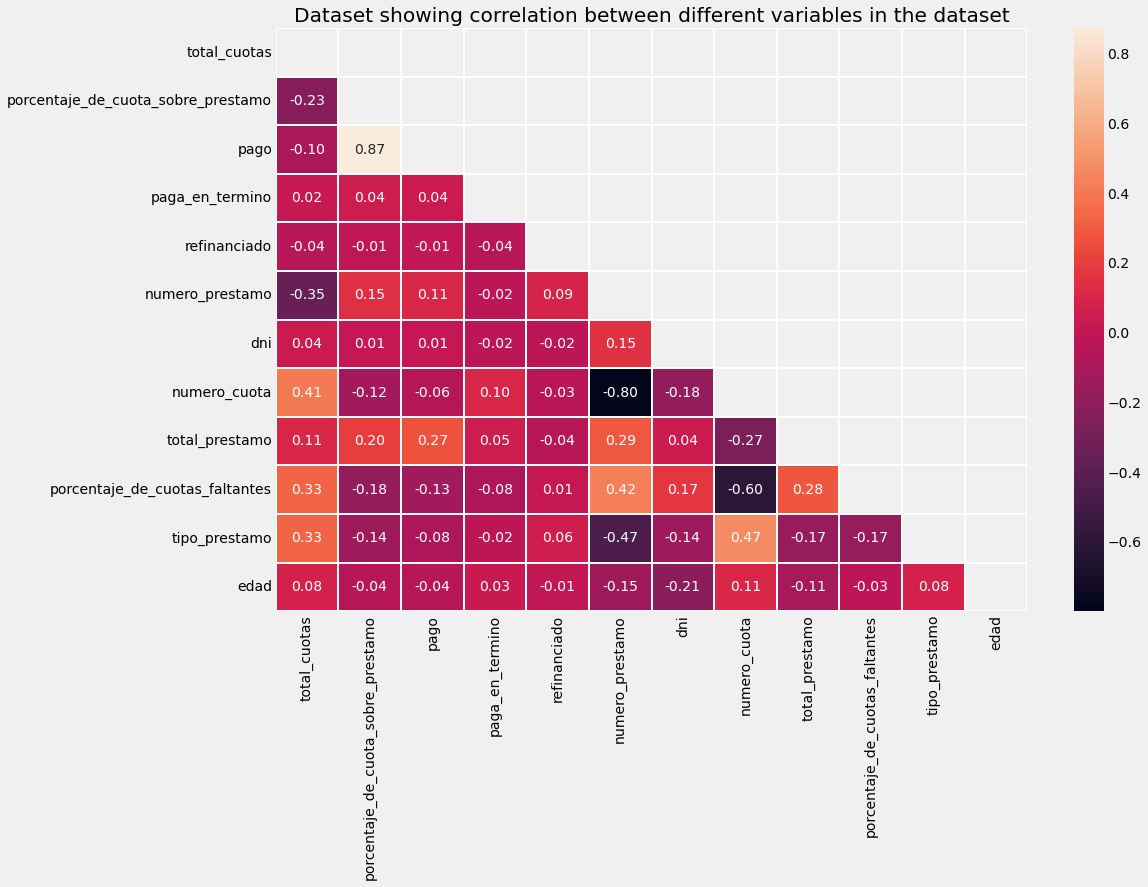

In [110]:
corr = df_4_parsed.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.2, mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

In [50]:
price_range_corr =  corr.paga_en_termino.sort_values(ascending = False)
price_range_corr_top = price_range_corr.head(10)
price_range_corr_bottom = price_range_corr.tail(10)
print ('top corr: \n{} \n\nbottom corr: \n{}'.format(price_range_corr_top, price_range_corr_bottom))

top corr: 
paga_en_termino                       1.000000
numero_cuota                          0.102861
total_prestamo                        0.048156
porcentaje_de_cuota_sobre_prestamo    0.044177
pago                                  0.036872
edad                                  0.025962
total_cuotas                          0.017970
tipo_prestamo                        -0.019913
dni                                  -0.021937
numero_prestamo                      -0.023156
Name: paga_en_termino, dtype: float64 

bottom corr: 
total_prestamo                        0.048156
porcentaje_de_cuota_sobre_prestamo    0.044177
pago                                  0.036872
edad                                  0.025962
total_cuotas                          0.017970
tipo_prestamo                        -0.019913
dni                                  -0.021937
numero_prestamo                      -0.023156
refinanciado                         -0.044470
porcentaje_de_cuotas_faltantes       -0.08

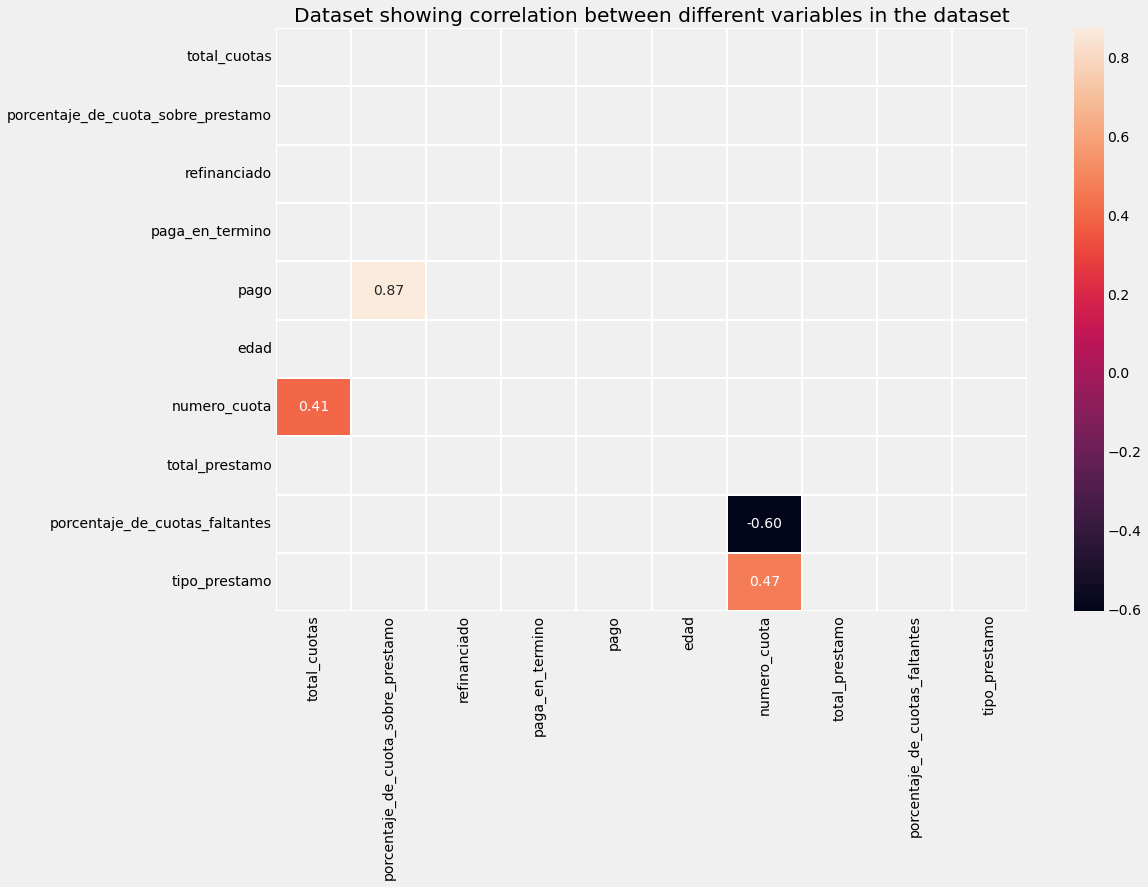

In [109]:
columns_data_corr = list(set(columns_data)&set(corr.columns))
corr_filter = corr[(corr>0.4) | (corr<-0.4)][columns_data_corr].copy()
corr_filter = corr_filter.filter(items = columns_data_corr, axis=0)
mask = np.triu(np.ones_like(corr_filter))
corr_filter.shape

plt.figure(figsize=(15,10))
sns.heatmap(corr_filter, annot=True, fmt='.2f', linewidths=.2,mask=mask)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()